|  name             | email            | github      |
| ------            | ------           | ------      |
|Patrick Vongphakdy | pvong2@uic.edu   | patvong224  |
|Brian Zbojna       | bzbojn2@uic.edu  | bzbojn2     |
|Michael Carnowell  | mcarno2@uic.edu  | carnowell   |

https://github.com/CS418/group-project-team-import-antigravity

https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

# Project Introduction

For our project, we decided to analyze a Formula One dataset in order to answer a few questions about the history of the sport. We wanted to see if we could find any correlations or trends in: Drivers failing to finish a race (DNFing), what effect pit stops had on races, and how competitive the sport was overall (can any driver win any race?). To do this, we used lap times, race results, pit stop times, and other data from our dataset. We wanted to provide an overview of how these questions affect the sport in general, and how it has changed over time.

# DNF Analysis

## Data Cleaning

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import string

standingsDF = pd.read_csv('data/driver_standings.csv')
lapTimesDF = pd.read_csv('data/lap_times.csv')
resultsDF = pd.read_csv('data/results.csv')

# Helper function to add DNF column
def DNFHelper(row):
    if row['positionText_x'] == 0:
        DNF = 1
    else:
        DNF = 0
    
    return DNF
    

helperDF = resultsDF

print("Before Cleaning: ", helperDF.shape, helperDF.columns)

# Replaces all of our DNFs to 0 to be used in our linear regression
helperDF = pd.merge(helperDF, standingsDF, on = ['driverId', 'raceId'])
helperDF = helperDF.replace(to_replace=['R', 'D', 'E', 'W', 'F', 'N'], value= 0, regex = True)

# Adding the DNF column to our dataframe
helperDF['DNF'] = helperDF.apply(DNFHelper, axis = 1)

allDF = helperDF.loc[:, helperDF.columns != 'positionText']

allDF = allDF.drop(['positionOrder'], axis = 1)
allDF = allDF.drop(['position_x'], axis = 1)
allDF = allDF.drop(['position_y'], axis = 1)
allDF = allDF.drop(['laps'], axis = 1)
allDF = allDF.drop(['positionText_x'], axis = 1)
allDF = allDF.drop(['positionText_y'], axis = 1)
allDF = allDF.drop(['points_x'], axis = 1)
allDF = allDF.drop(['statusId'], axis = 1)
allDF = allDF.drop(['time'], axis = 1)

allDF['fastestLapTime'] = allDF['fastestLapTime'].str.replace('[^\w\s]','')
allDF['fastestLapSpeed'] = allDF['fastestLapSpeed'].str.replace('[^\w\s]','')

allDF = allDF.fillna(0)

print("After Cleaning: ", allDF.shape, allDF.columns)

Before Cleaning:  (25660, 18) Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')
After Cleaning:  (25191, 15) Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'driverStandingsId', 'points_y', 'wins', 'DNF'],
      dtype='object')


C:\Users\Michael\AppData\Local\Temp\ipykernel_10736\2709934728.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  allDF['fastestLapTime'] = allDF['fastestLapTime'].str.replace('[^\w\s]','');
C:\Users\Michael\AppData\Local\Temp\ipykernel_10736\2709934728.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  allDF['fastestLapSpeed'] = allDF['fastestLapSpeed'].str.replace('[^\w\s]','');


Before running our Linear Regression, we had to prune some of the columns off of our dataframe. Particularly, we got rid of the positionOrder, position_x, position_y, laps, positionText_x, positionText_y, points_x, and statusId. We had to get rid of these columns because they wouldn't be able to be used to predict a future DNF. Since these columns refer data collected AFTER the race, it's not much use for the task that we're looking to accomplish. We also had many missing fastestLapTimes and fastestLapSpeeds, so we filled in the NaN values with 0.

## Exploratory Data Analysis

In [59]:
resultsDF.shape

(25660, 18)

We see that we have a very comprehensive dataset. We have 18 columns, and 25660 rows/entries.

In [60]:
resultsDF.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

Quantitative Discrete:
resultId, raceId, driverId, constructorId, number, grid, points, laps, milliseconds, fastestLap

Quantitative Continuous:
time, fastestLapTime, fastestLapSpeed

Categorical Nominal:
none

Categorical Ordinal:
position, positionText, positionOrder, rank

Some interesting pieces of data are the position and positionText columns. Position indicates the final position of a driver at that specific race. However, we know that some drivers don't necessarily finish every race, due to a number of issues. To circumnavigate this, we could use the positionOrder column, which indicates the final rank of a driver at a specific race. This allows us to collect data on final finishing positions without having to take DNF's into account.

Although we're able to bypass DNF's for the final finishing positions, the same can't be said for other data collected from that driver that race. For example, what happens when a driver can't complete a lap before they retire? We won't have that driver's fastestLapTime, fastestLapSpeed, and rank values. 

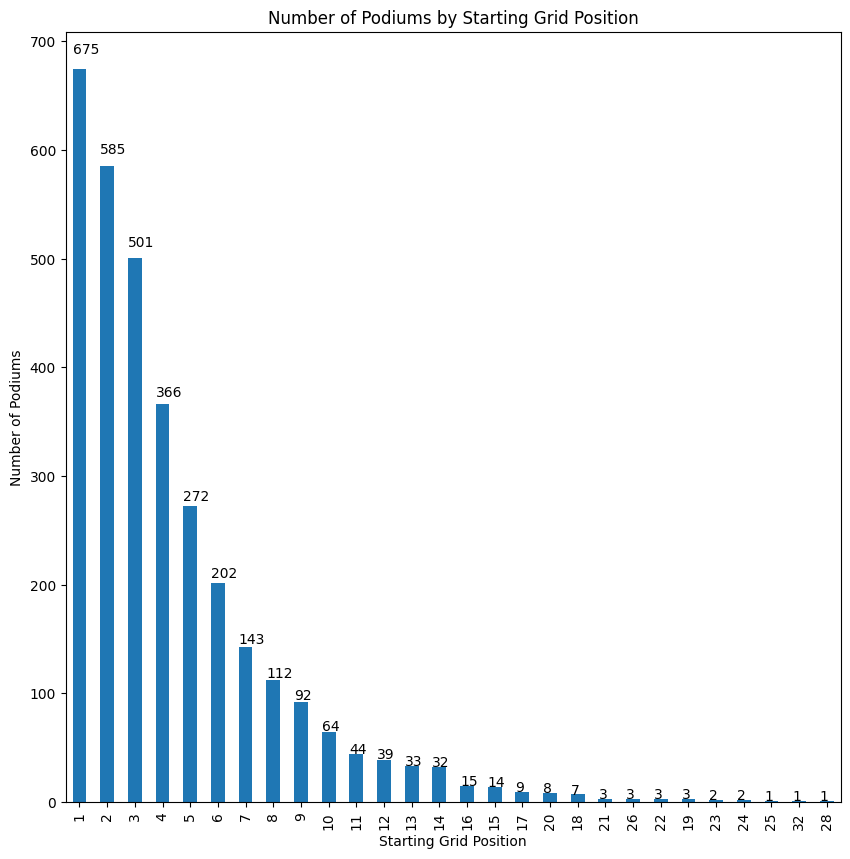

In [101]:
podiumDF = resultsDF[['positionOrder', 'grid']]
podiumDF = podiumDF.loc[podiumDF['positionOrder'] <= 3]

podiumGraph = podiumDF['grid'].value_counts().plot.bar(figsize = (10, 10), title = 'Number of Podiums by Starting Grid Position')
podiumGraph.set_xlabel('Starting Grid Position')
podiumGraph.set_ylabel('Number of Podiums')

for label in podiumGraph.patches:
    podiumGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

plt.show();

As we can see from the following visualization, out of 3,232 podium results, 1,761, or 54.49% were achieved from drivers who qualified in the top 3 positions. This indicates that qualifying top 3 is a large advantage in the final race.

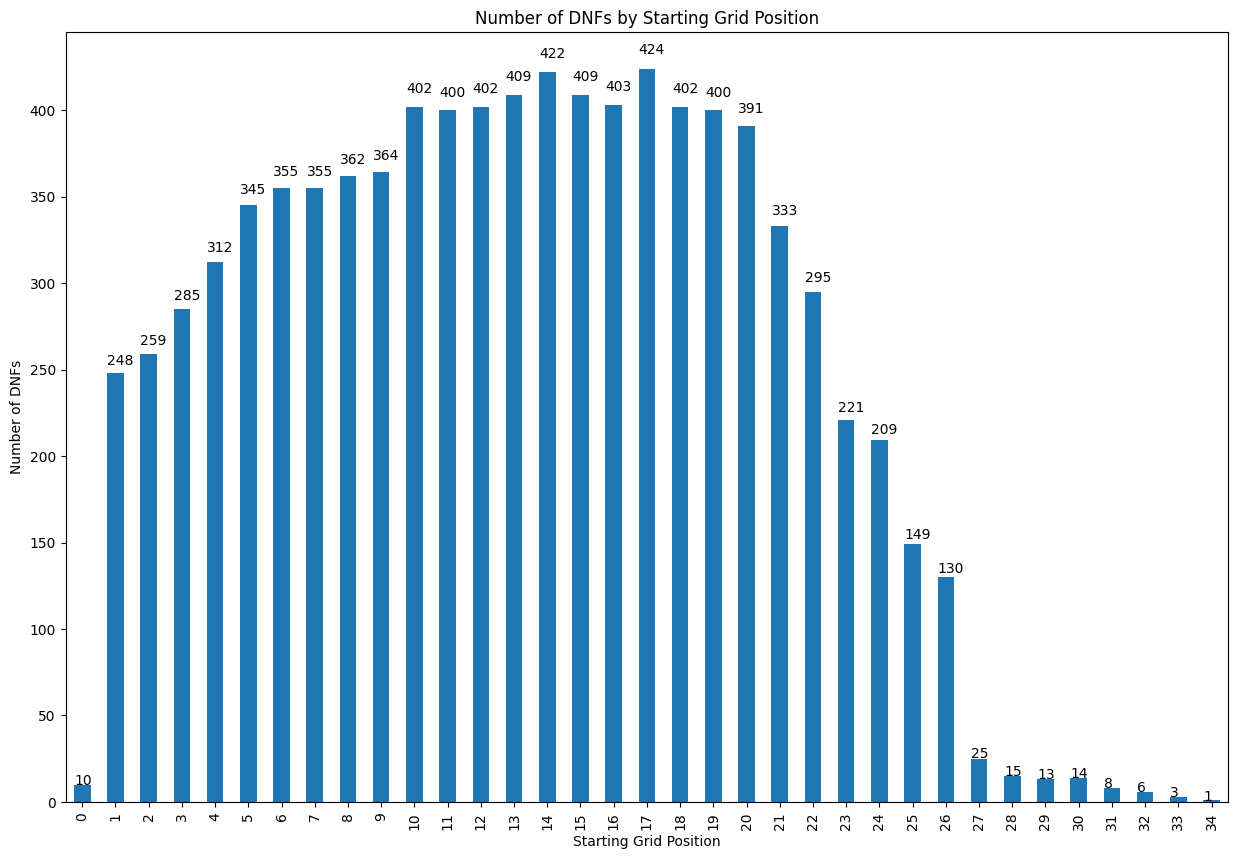

In [102]:
dnfDF = resultsDF[['grid', 'positionText']]
dnfDF = dnfDF.loc[dnfDF['positionText'] == 'R']

dnfGraph = dnfDF['grid'].value_counts().sort_index().plot.bar(figsize = (15, 10), title = 'Number of DNFs by Starting Grid Position',)
dnfGraph.set_xlabel('Starting Grid Position')
dnfGraph.set_ylabel('Number of DNFs')

for label in dnfGraph.patches:
    dnfGraph.annotate(str(label.get_height()), (label.get_x(), label.get_height() * 1.02))

plt.show();

This visualization shows an interesting trend. The top 11 grid positions in terms of number of DNFs are all in the bottom half of the possible starting grid positions. Additionally, these 11 grid positions account for 4464 total DNFs out of the 8781 overall DNFs. In other words, around 51% of DNFs came from drivers who started in these grid positions. This raises the question of why so many DNFs come from those starting grid positions. Are drivers further in the back of the pack more likely to get into crashes? Do these drivers push their cars harder to make up for their poor qualifying performances? 

## Machine Learning and Statistics

In [63]:
xTrain, xTest, yTrain, yTest = train_test_split(allDF, helperDF.DNF, test_size = 0.2)

dnfRegression = LinearRegression()

rfe = RFE(estimator = dnfRegression, n_features_to_select = 4, step = 1)
rfe.fit(xTrain, yTrain)
# grid, rank, and wins are the top 3 features
print(rfe.support_)
print(rfe.ranking_)

topThreeFeats = helperDF[['rank', 'laps', 'grid']]

topXTrain, topXTest, topYTrain, topYTest = train_test_split(topThreeFeats, helperDF.DNF, test_size = 0.2)

rfeRegression = LinearRegression()

rfeRegression.fit(topXTrain, topYTrain)

rfeYPred = rfeRegression.predict(topXTest)
rfeYTrainPred = rfeRegression.predict(topXTrain)

[False False False False False False False  True  True False False False
 False  True  True]
[ 8  3  7  6  2  5 11  1  1 12  9 10  4  1  1]


As we can see, our RFE selects the top 3 features to predict whether or not a DNF will happen. The 3 features the RFE picked were grid, rank, and wins. Grid refers to the starting grid position, rank refers to the ranking of the driver's fastest lap, and wins refers to the number of wins that driver has that season.

## Results

In [64]:
print('Intercept: ', rfeRegression.intercept_)

print('r-squared: %.2f' % r2_score(topYTest, rfeYPred))

print('for training: %.2f' % mean_squared_error(topYTrain, rfeYTrainPred))

print('for testing: %.2f' % mean_squared_error(topYTest, rfeYPred))

Intercept:  0.8932898891931826
r-squared: 0.49
for training: 0.12
for testing: 0.12


Our intercept is 0.89, meaning that if a driver starts from the pitlane, has the fastest lap time, and has no wins, they're very likely to DNF. Furthermore, our r-squared value is 0.48, meaning that the relationship between our regression and DNFs is around 48%. This means our model isn't the greatest fit for our data. Our Mean Squared Error values for both training and testing are around 0.12, meaning that we have a very low rate of error in prediction. This tells us that the three features the RFE picked are very effective in predicting a future DNF. 

# Pit Stop Analysis

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

ptdf = pd.read_csv("data/pit_stops.csv")
lpdf = pd.read_csv("data/lap_times.csv")

ptdf.rename(columns = {'lap':'pit_lap', 'time':'pit_time', 'milliseconds':'pit_ms'}, inplace = True)
df = pd.merge(ptdf, lpdf, on = 'driverId', how = 'inner')
df.drop('raceId_y', axis = 1, inplace = True)
df.head()

,raceId_x,driverId,stop,pit_lap,pit_time,duration,pit_ms,lap,position,time,milliseconds
0,841,153,1,1,17:05:23,26.898,26898,1,21,2:13.879,133879
1,841,153,1,1,17:05:23,26.898,26898,2,21,1:40.659,100659
2,841,153,1,1,17:05:23,26.898,26898,3,21,1:33.293,93293
3,841,153,1,1,17:05:23,26.898,26898,4,21,1:33.144,93144
4,841,153,1,1,17:05:23,26.898,26898,5,21,1:33.320,93320


We want to see if there is a correlation with pit stop times and lap times. I believe that we can truly see how important pit times are to winning lap times. In order to analyze a correlation, it would be best to merge the times together.We know that generations of racers and progression of technology can shorten both times, and this should still be present in our analysis.

Because of the massive size of the database, we need to get a random sample in order to get a proper graph. We also need to normalize the data in order to accurately present the data. This is because each circuit has varying lap and pit times due to the many different types of courses. From the circuit's length, corners, to DRS zones of each course, we would need a way to effectively show how the two times would correlate.

## Data Cleaning

In [87]:
df_norm_pt = df['pit_ms']/df['pit_ms'].abs().max()
df_norm_lp = df['milliseconds']/df['milliseconds'].abs().max()

There isn't much data to be cleaned, but here we will normalize the data for analysis on the correlation. 

## Exploratory Data Analysis

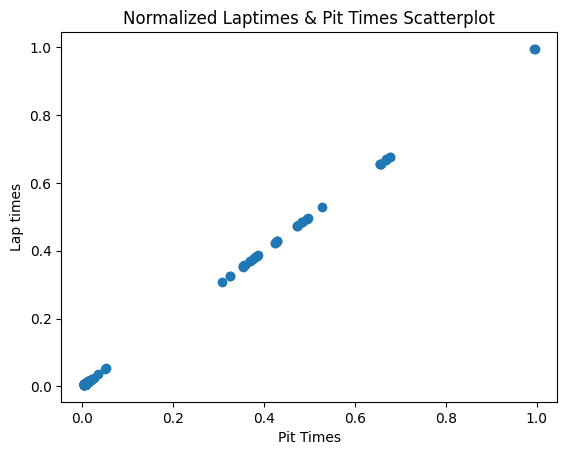

In [88]:
plt.scatter(df_norm_pt.sample(1500, random_state = 1), df_norm_pt.sample(1500, random_state = 1))
plt.xlabel('Pit Times')
plt.ylabel('Lap times')
plt.title("Normalized Laptimes & Pit Times Scatterplot")
plt.show();

From the normalized graph, we can see that there is a positive linear relationship between pit times and lap times. This is also from the random samples that we generated from the dataframe. Now this is just a visual representation of a small group of races and drivers.

We will dive deeper into finding correlations and 

## Machine Learning and Statistics

Now lets take a deeper dive into the correlations. We have made variables for the normalized times and will use that for our correlation testing.

In [89]:
#df_norm_times = pd.merge(df['pit_ms'], df['milliseconds'], right_index=True, left_index=True)
df[['pit_ms','milliseconds']].sample(1500, random_state = 1).corr()

,pit_ms,milliseconds
pit_ms,1.000000,-0.005835
milliseconds,-0.005835,1.000000


From this, we can that there actually isn't a correlation between the two variables. To see this more, let's use the original, un-normalized variables from the same random sample. We also decided to set a boundry for the plot to remove outliers.

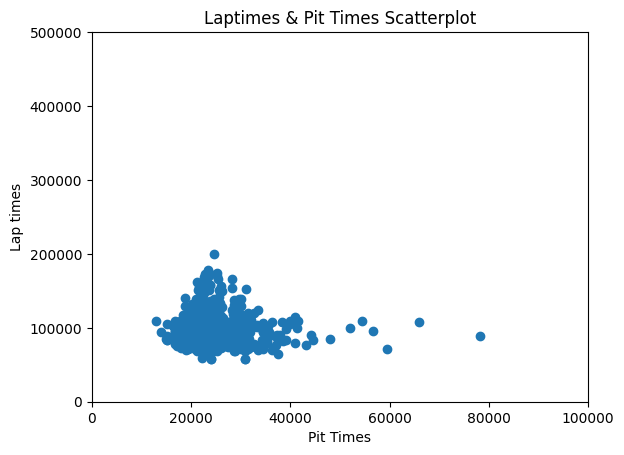

In [90]:
plt.scatter(df['pit_ms'].sample(1500, random_state = 1), df['milliseconds'].sample(1500, random_state = 1))
plt.xlabel('Pit Times')
plt.ylabel('Lap times')
plt.title("Laptimes & Pit Times Scatterplot")
plt.xlim([0,100000])
plt.ylim([0,500000])
plt.show();

Now lets use machine learning on predicting position with pit stops and milliseconds. We are using an SVM to classify different positions one could have with said times.

In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['pit_ms', 'milliseconds']].sample(500, random_state = 1), 
    df['position'].sample(500, random_state = 1),
    test_size=0.20, random_state=0)

In [71]:
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)

SVC(kernel='linear')

In [72]:
y_pred = clf.predict(x_test)
print("Accuracy of SVM =", metrics.accuracy_score(y_test, y_pred))

Accuracy of SVM = 0.07


## Results

We can see that there is now no correlation between lap and pit times. Normalizing the data did not properly assess the two variables in finding a correlation. 
But using the corr function and using the base data, we can properly see that there is no correlation between teams and drivers pit times to lap times.

Our SVM model had a 0.07 accuracy, which means that the model was not accurate at all. This could add to Michael's theory that position; which is a direct correlation with points, doesn't matter and distributed evenly among drivers. This also leads to Michael's other statement thatwe can't predict a drivers finishing position from their times as well.

# Competition Analysis

## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

results = pd.read_csv('data/results.csv')
races = pd.read_csv('data/races.csv')

df = pd.merge(results, races, on = ['raceId'])

df = df.drop(['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time',
'fp3_date', 'fp3_time', 'url', 'quali_date', 'quali_time',
'sprint_date', 'sprint_time', 'date', 'time_y', 'name',
'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x'], axis = 1)

df = df[df['year'] != 2022]

test = df.groupby(['driverId', 'year'])['points'].apply(sum)
test = test.reset_index()

df.head(10)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,milliseconds,fastestLap,rank,year,round,circuitId
0,1,18,1,1,22,1,1,1,1,10.0,58,5690616,39,2,2008,1,1
1,2,18,2,2,3,5,2,2,2,8.0,58,5696094,41,3,2008,1,1
2,3,18,3,3,7,7,3,3,3,6.0,58,5698779,41,5,2008,1,1
3,4,18,4,4,5,11,4,4,4,5.0,58,5707797,58,7,2008,1,1
4,5,18,5,1,23,3,5,5,5,4.0,58,5708630,43,1,2008,1,1
5,6,18,6,3,8,13,6,6,6,3.0,57,\N,50,14,2008,1,1
6,7,18,7,5,14,17,7,7,7,2.0,55,\N,22,12,2008,1,1
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,20,4,2008,1,1
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,15,9,2008,1,1
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,23,13,2008,1,1


First, we're going to remove columns we don't need for this analysis. Also, we're going to remove any records from 2022 because the 2022 season of Formula One has not yet finished. we're also going to group driver points by season and by driver to find each driver's final number of points for the season.

## Exploratory Data Analysis

We decided to use the Gini coefficient with the number of points each driver received for a season to determine how 'competitive' a season was. Points are awarded per race, and are based on finishing position. They are not awarded linearly, i.e. the points awarded follow the distribution 25, 18, 15, 12, 10, 8, 6, 4, 2, 1, for the top ten drivers in a race respectively. Since the Gini coefficient measures how evenly some metric is distributed throughout a population, we thought this would make a good corollary to examine how competitively balanced the sport is. Although the total number of points distributed, and the exact distrbutions have changed a few times throughout the history of the sport, the gini coefficient is not affected by this because it represents percentages and not absolute totals.

In [2]:
# https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy

def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

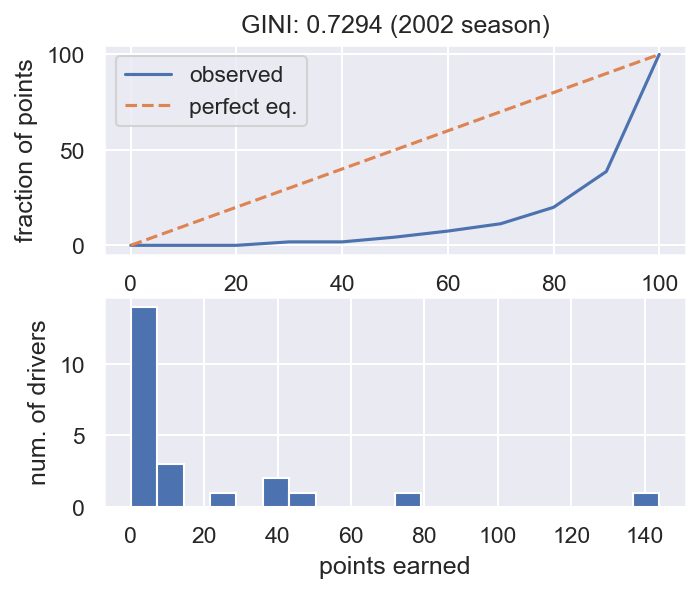

In [4]:
season_2002 = df.groupby(['year', 'driverId'])['points'].apply(list)
season_2002 = season_2002.reset_index()
season_2002 = season_2002[season_2002['year'] == 2002]
season_2002['total_points'] = list(map(lambda x: sum(x), season_2002['points']))

# v = np.random.rand(500)
v = season_2002['total_points'].values
bins, result, gini_val = G(v)


plt.figure(dpi = 150, figsize = (5, 4));
plt.subplot(2, 1, 1);
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.ylabel("fraction of points")
plt.xlabel('fraction of driver population')
plt.title("GINI: %.4f (2002 season)" %(gini_val))
plt.legend();
plt.subplot(2, 1, 2);
plt.xlabel("points earned")
plt.ylabel('num. of drivers')
plt.hist(v, bins=20);
plt.show();

This is an example of what the Gini coefficient shows us for an individual season. We can see that the distribution of points among drivers is quite uneven for this particular season (0.7294). We can see that one particular driver has achieved a large majority of the points available (140), and that only five other drivers have earned a significant number of points.

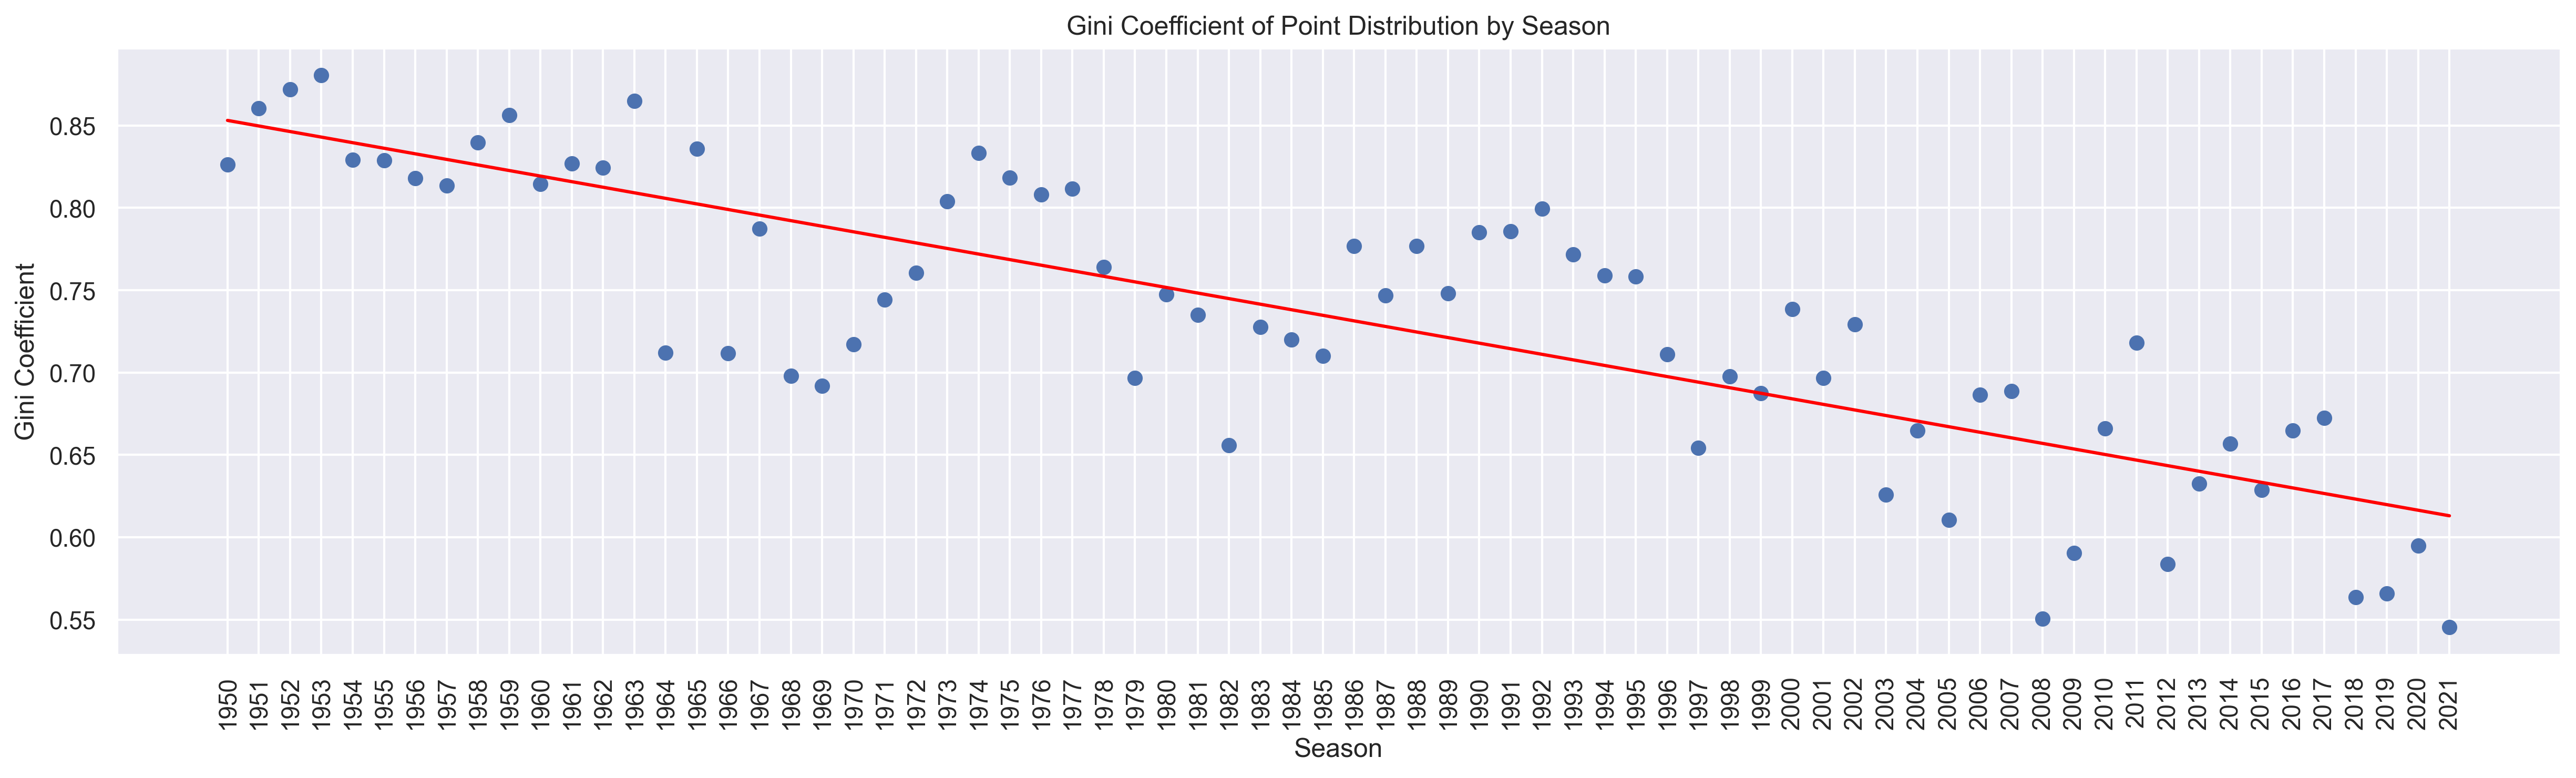

In [5]:
point_totals = df.groupby(['year', 'driverId'])['points'].apply(sum).reset_index()
years = []
ginis = []
for y in point_totals['year'].unique():
    cur = point_totals[point_totals['year'] == y]
    v = cur['points'].values
    bins, result, gini_val = G(v)
    years.append(y)
    ginis.append(gini_val)

asdf = list(zip(years, ginis))
gc = pd.DataFrame(asdf, columns = ['year', 'gini coefficient'])

plt.figure(figsize = (20, 5), dpi = 300);

# https://www.statology.org/matplotlib-trendline/
trend = np.poly1d(np.polyfit(years, ginis, 1))
plt.plot(years, trend(years), color = 'red')

# plt.plot(years, ginis);
plt.scatter(x = years, y = ginis)
plt.xticks(years, rotation = 90);
plt.ylabel('Gini Coefficient')
plt.xlabel('Season')
plt.title('Gini Coefficient of Point Distribution by Season')
plt.show();


We can see that there is in fact a trend in the Gini coeffcient of each season over time, and that it is dropping. Generally we would consider this a positive result, as a lower Gini coefficient means that points are becoming more evenly distributed amongst drivers, and the sport is more competitive. However, this analysis does not quite address the full picture. In order to contextualize this result, we also examined how many different drivers ever finish in first, second, or third place ('on the podium') per season.

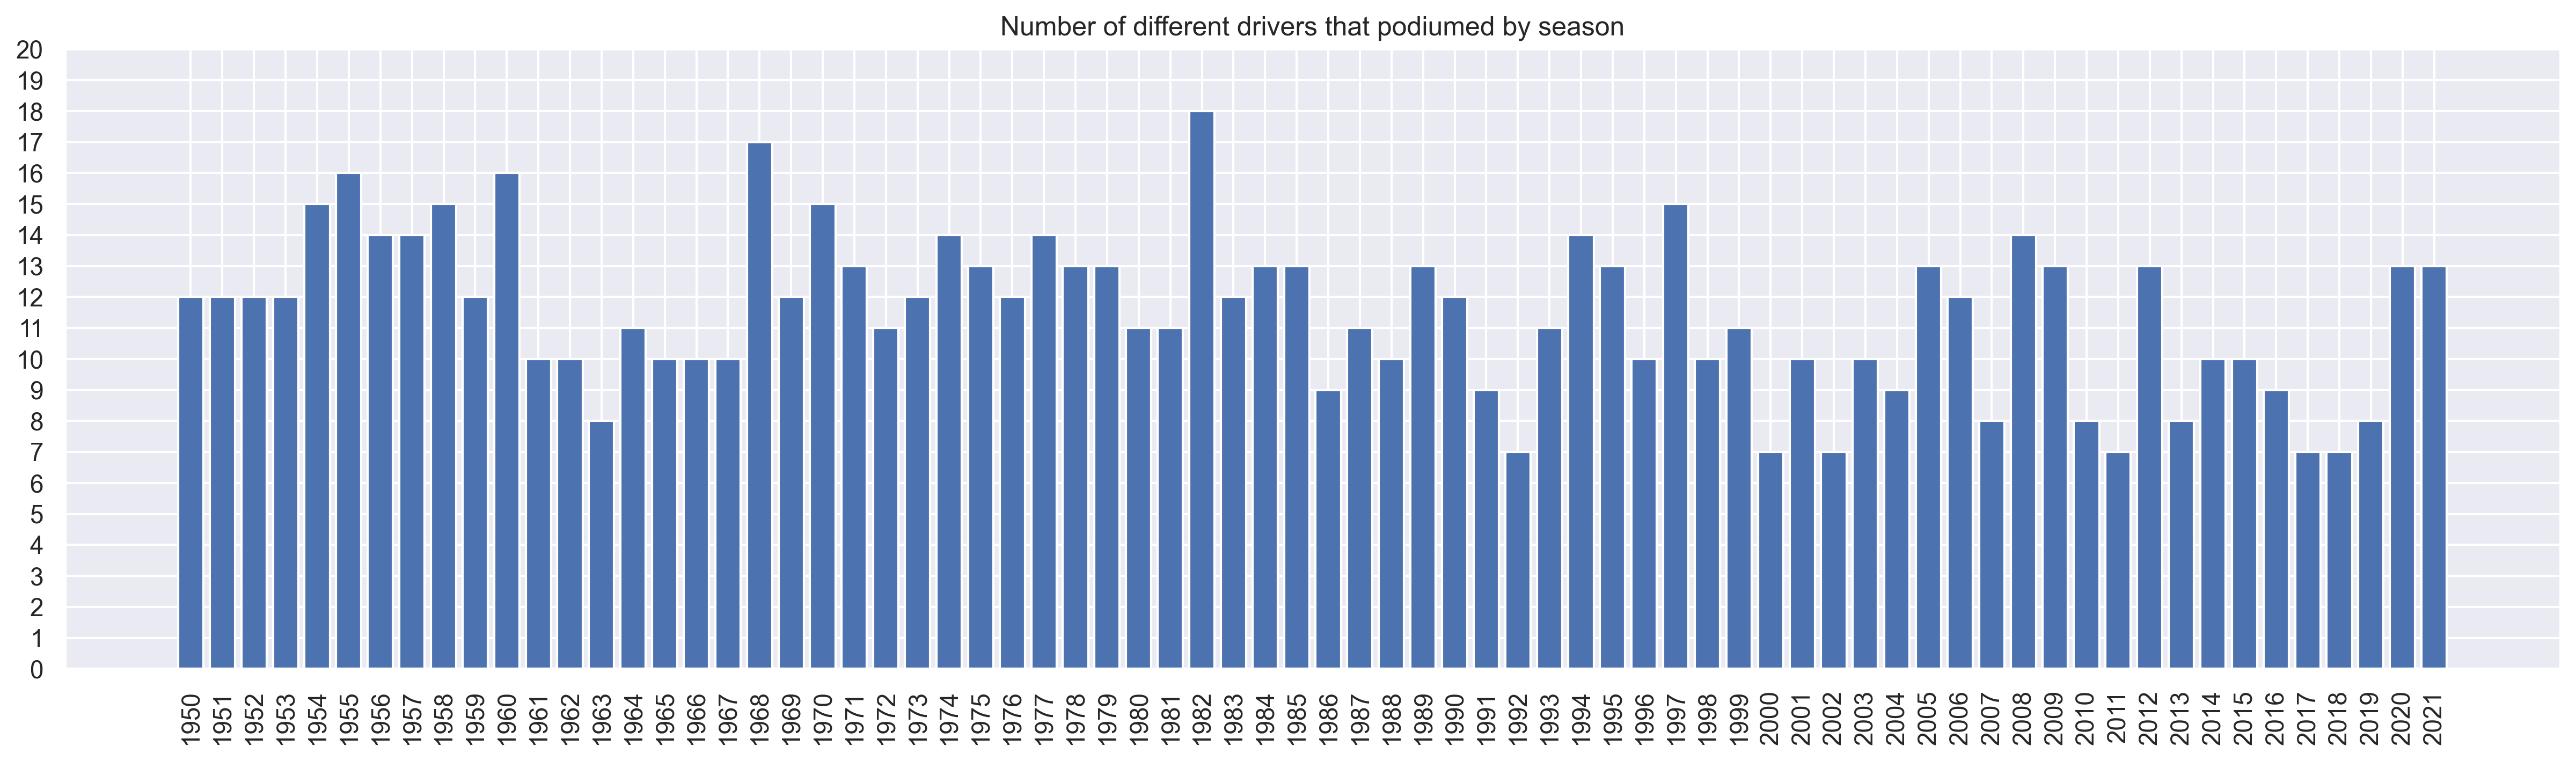

,0,1
0,1.000000,0.136206
1,0.136206,1.000000


In [6]:
unique_podiums = pd.merge(races, results, on = ['raceId'])
unique_podiums = unique_podiums.groupby(['year', 'position'])['driverId'].apply(list)
unique_podiums = unique_podiums.reset_index()
unique_podiums = unique_podiums[unique_podiums['position'] != '\\N']
unique_podiums = unique_podiums[unique_podiums['year'] != 2022]
unique_podiums['position'] = unique_podiums['position'].astype(int)
unique_podiums = unique_podiums[unique_podiums['position'] <= 3]
unique_podiums = unique_podiums.groupby(['year'])['driverId'].apply(list)
unique_podiums = unique_podiums.reset_index()
unique_podiums['driverId'] = list(map(lambda x: x[0]+x[1]+x[2], unique_podiums['driverId']))
unique_podiums['diff_podiums'] = list(map(lambda x: len(np.unique(x)), unique_podiums['driverId']))


plt.figure(dpi = 300, figsize = (20, 5))
plt.bar(x = years, height = unique_podiums['diff_podiums'])
plt.xticks(years, rotation = 90);
plt.yticks(np.arange(0, 21, 1))
plt.title('Number of different drivers that podiumed by season')
plt.show();

check_corr = pd.DataFrame(list(zip(unique_podiums['diff_podiums'], ginis)))
check_corr.corr()

Although the Gini coefficient is on a downward trend over time, we can see that actually the number of different drivers that podium per season is not really affected. You can also see that there is a very weak correlation between how many different drivers podiumed in a season and that season's Gini coefficient. This seems to indicate that although the points are being distributed more evenly amongst drivers, this effect seems to mainly occur lower down in the standings, outside of the fight for the podium in each race. While this could certainly lead to interesting racing in the middle of the pack, it does not indicate that the sport is significantly more competitive, or that any driver has a chance to win any race, as we would like to imagine.

## Machine Learning and Statistics

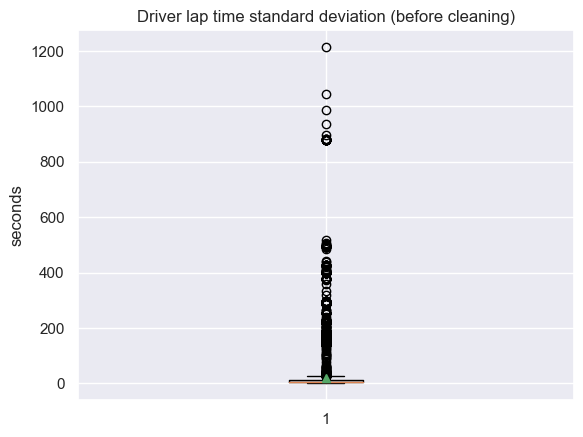

In [7]:
lap_times = pd.read_csv('data/lap_times.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')

df = pd.merge(lap_times, races, on = ['raceId'])

test = df.groupby(['raceId', 'driverId', 'year'])['milliseconds'].apply(list)
test = test.reset_index()
test['num_laps'] = test['milliseconds'].apply(len)
# Because n = 30 is a big deal and stuff
test = test[test['num_laps'] >= 30]
test['std_dev'] = list(map(lambda x: np.asarray(x).std()/1000, test['milliseconds']))

plt.boxplot(x= test['std_dev'].values, showmeans = True);
plt.title("Driver lap time standard deviation (before cleaning)")
plt.ylabel("seconds")
plt.show();



Another aspect of Formula One we wanted to investigate was driver consistency. Consistency is often considered to be the highest mark of achievement for any Formula One driver, and it is usually considered to be analogous with skill. In order to test this theory, we decided to see if we could predict what position a driver would finish a race in based on his starting grid position, and how consistent he was during the race. We measure consistency as the standard deviation of a driver's lap times throughout a race.

Firstly however, we can see the data needs cleaning, as there are a large number of outliers over an extremely wide range. We'll remove any outliers, any laps for a driver who did not finish a race, and any driver who finished beyond 20th position because there are only a few seasons with more than 20 drivers competing.

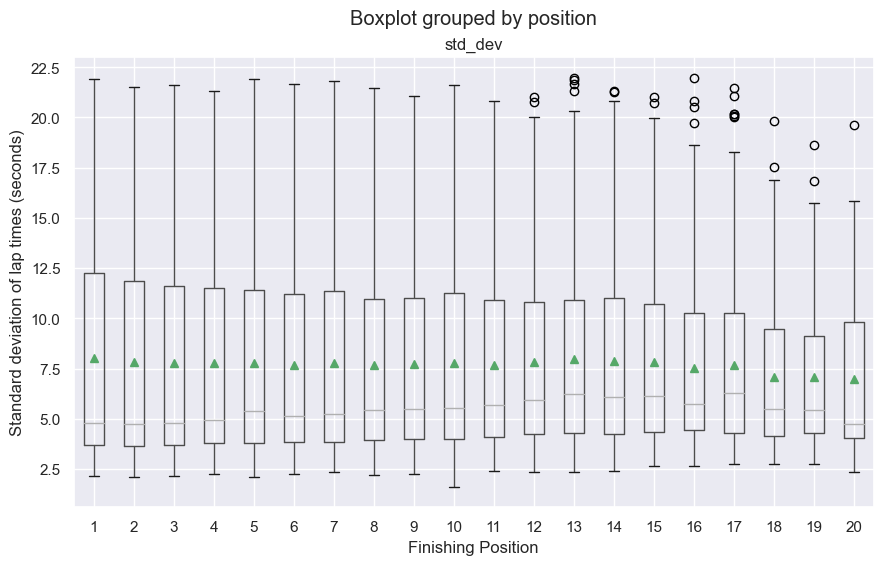

,std_dev,position
std_dev,1.000000,-0.018978
position,-0.018978,1.000000


In [8]:
test = test[test['std_dev'] < 22]
std_and_pos = pd.merge(test, results, on = ['raceId', 'driverId'])
std_and_pos = std_and_pos[std_and_pos['position'] != '\\N']
std_and_pos['position'] = std_and_pos['position'].astype(int)
std_and_pos = std_and_pos[std_and_pos['position'] <= 20]
std_and_pos.boxplot(column = ['std_dev'], by = ['position'], figsize = (10, 6),
    showmeans = True, xlabel = 'Finishing Position',
    ylabel = 'Standard deviation of lap times (seconds)')
plt.show();
corr = std_and_pos[['std_dev', 'position']]
corr = corr[corr['position'] != '\\N']
corr['position'] = corr['position'].astype(int)
corr.corr()

We can see in fact, that contrary to popular belief there is essentially no correlation between consistency and finishing position. All the drivers on the grid seem to be relatively equally consistent. The only trend that seems to occur is the shrinking of the inner quartiles per position, indicating a slightly wider range of data as we go lower in finishing position.

Accuracy
0.16522988505747127


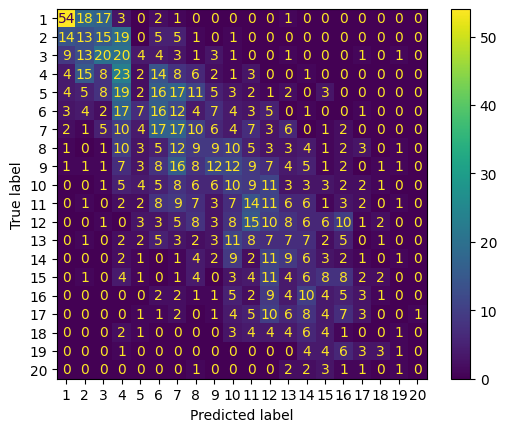

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

df = pd.merge(results, races, on = ['raceId'])
df = df.drop(['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time',
'fp3_date', 'fp3_time', 'url', 'quali_date', 'quali_time',
'sprint_date', 'sprint_time', 'date', 'time_y', 'name',
'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x', 'milliseconds'], axis = 1)
df = df[df['year'] != 2022]
test = df.groupby(['driverId', 'year'])['points'].apply(sum)
test = test.reset_index()

lap_times = pd.read_csv('data/lap_times.csv')
df2 = pd.merge(lap_times, races, on = ['raceId'])

test2 = df2.groupby(['raceId', 'driverId', 'year'])['milliseconds'].apply(list)
test2 = test2.reset_index()
test2['num_laps'] = test2['milliseconds'].apply(len)
# Because n = 30 is a big deal and stuff
test2 = test2[test2['num_laps'] >= 30]
test2['std_dev'] = list(map(lambda x: np.asarray(x).std()/1000, test2['milliseconds']))
test2 = test2[test2['std_dev'] < 22]

test = df[['raceId', 'driverId', 'year', 'grid', 'position']]
test = test[test['position'] != '\\N']
test['position'] = test['position'].astype(int)
test = test[test['position'] < 21]
test.corr()

# Reset style so confusion matrix is readable
plt.style.use('default')

test = pd.merge(test, test2, on = ['raceId', 'driverId'])

X_train, X_test, y_train, y_test = train_test_split(test[['grid', 'std_dev']],
    test['position'].values, train_size = 0.8, random_state = 0)
cnb = CategoricalNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print("Accuracy")
print(accuracy_score(y_pred, y_test))
cm = confusion_matrix(y_test, y_pred, labels = cnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = cnb.classes_)
disp.plot();
plt.show();

As we can see, the accuracy for our Categorical Naive Bayes model predicting finishing position from a driver's starting position and lap time standard deviation is very poor. An accuracy of 0.165 is only ~3 times as good as guessing randomly. The positive outcome of this result is that starting position is not highly predictive of finishing position in a race, which could indicate more interesting races. But of course, we can see that our chosen metric has failed to provide any insight into Formula One results. We can safely say that it is time to stop parroting the adage that consistency is king.

## Results

We achieved very mixed results. By far, our best analysis was our DNF predictions, which achieved $r^2 = 0.49$ using a driver's starting grid position, rank, and number of wins to determine whether or not they would DNF in a particular race. Our pit stop analysis did not prove as insightful, showing that there is very little to no correlation between how long a driver's pit stops take, and their lap times. Our investigation into the distribution of driver points amongst drivers per season using the Gini coefficient revealed an interesting downward trend in season Gini coefficients over time, but we also saw that this is unrelated to how many different drivers podium per season. Additionally, we learned that the traditional wisdom of measuring a driver by their consistency is not as relevant as many fans and commentators believe it to be. There was almost no correlation between a driver's consistency, and their finishing position in a race. Overall, we believe that while not all of our results were positive, they all provided interesting insight into what relationships exist in Formula One. We learned that DNFs are more predictable than previosuly believed, that pit stops do not drastically affect race outcomes, and that the sport is highly stratified competitively, between a few top drivers and the rest of the pack.

# References

1. https://www.geeksforgeeks.org/normalize-a-column-in-pandas/

2. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

3. https://sparkbyexamples.com/pandas/pandas-combine-two-series-into-dataframe/#:~:text=Combine%20Two%20Series%20Using%20pandas.&text=merge()%20can%20be%20used,True%2C%20left_index%3DTrue

4. https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

5. https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy

6. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

7. https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
